In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [2]:
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
def rmsle(h, y): 
    """
    Compute the Root Mean Squared Log Error for hypthesis h and targets y

    Args:
        h - numpy array containing predictions with shape (n_samples, n_targets)
        y - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())


train = pd.read_csv("../data/train-290118.csv")
test = pd.read_csv("../data/test_290118.csv")
test_id=test.id

In [5]:
vector = np.vstack((train[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']].values,
                    test[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']].values))

pca = PCA().fit(vector)
train['vector_pca0'] = pca.transform(train[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']])[:, 0]
test['vector_pca0'] = pca.transform(test[['lattice_vector_1_ang', 'lattice_vector_2_ang','lattice_vector_3_ang']])[:, 0]


In [6]:
dist_features = [x for x in train.columns.tolist() if x.startswith('dist')]
path_features = [x for x in train.columns.tolist() if x.startswith('path')]
angle_features = [x for x in train.columns.tolist() if x.startswith('angle')]
dihedral_features = [x for x in train.columns.tolist() if x.startswith('dihedral')]
percent_features = [x for x in train.columns.tolist() if x.startswith('percent')]
avg_features = [x for x in train.columns.tolist() if x.startswith('avg')]
lattice_angle_features = [x for x in train.columns.tolist() if x.startswith('lattice_angle')]
clusters_features = [x for x in train.columns.tolist() if x.startswith('clusters_')]

In [5]:
features_fe = ['lattice_angle_alpha_degree',
               'lattice_angle_gamma_degree',
               'number_of_total_atoms',
               'vol',
               'atomic_density',
               'lattice_vector_1_ang',
               'lattice_vector_2_ang',
               'lattice_vector_3_ang',
               'vector_pca0']+avg_features+percent_features+dist_features+angle_features+dihedral_features

In [7]:
feature_engineering =['avg_IP',
                     'avg_rd_max',
                     'avg_LUMO',
                     'avg_electronegativity',
                     'avg_rp_max',
                     'percent_atom_in',
                     'percent_atom_al',
                     'percent_atom_ga',
                     'dist_23',
                     'dist_25',
                     'dist_16',
                     'dist_46',
                     'dist_15',
                     'dist_40',
                     'dist_33',
                     'dist_29',
                     'dist_18',
                     'dist_8',
                     'dist_77',
                     'dist_65',
                     'dist_47',
                     'dist_20',
                     'dist_30',
                     'dist_49',
                     'path_30',
                     'path_20',
                     'path_10',
                     'path_0',
                     'path_40',
                     'path_49',
                     'angle_179',
                     'angle_86',
                     'angle_169',
                     'angle_171',
                     'angle_95',
                     'angle_93',
                     'angle_121',
                     'angle_89',
                     'angle_108',
                     'angle_91',
                     'angle_165',
                     'dihedral_75',
                     'dihedral_154',
                     'dihedral_66',
                     'dihedral_7',
                     'dihedral_178',
                     'dihedral_97',
                     'dihedral_85',
                     'dihedral_131',
                     'dihedral_24',
                     'dihedral_91',
                     'dihedral_135',
                     'dihedral_79',
                     'dihedral_177',
                     'dihedral_119',
                     'dihedral_2',
                     'A_8',
                     'A_5',
                     'A_3',
                     'A_2',
                     'A_0',
                     'A_7',
                     'A_6',
                     'A_1',
                     'A_4',
                     'B_8',
                     'B_6',
                     'B_5',
                     'B_2',
                     'B_3',
                     'B_1',
                     'B_0',
                     'B_7',
                     'B_4',
                     'R_1',
                     'R_2',
                     'R_0',
                     'r_2',
                     'r_1',
                     'r_0',
                     'lattice_angle_sum_discrete_215',
                     'lattice_angle_sum_discrete_270',
                     'lattice_angle_sum_discrete_285',
                     'lattice_angle_sum_discrete_300',
                     'clusters_0',
                     'clusters_1',
                     'clusters_2',
                     'clusters_3',
                     'clusters_4',
                     'clusters_5',
                     'clusters_6',
                     'clusters_7',
                     'clusters_8',
                     'clusters_9',
                     'clusters_10']

In [8]:
X = train[feature_engineering]
Y_fe = np.log(train['formation_energy_ev_natom']+1)
Y_be = np.log(train['bandgap_energy_ev']+1)

test = test[feature_engineering]

In [34]:
def runCatBoost(x_train, y_train,x_test, y_test,test,depth):
    model=CatBoostRegressor(iterations=2400,
                            learning_rate=0.01,
                            depth=depth,
                            loss_function='RMSE',
                            eval_metric='RMSE',
                            random_seed=99,
                            l2_leaf_reg=4,
                            od_type='Iter',
                            task_type='CPU',
                            od_wait=50)
    model.fit(x_train, y_train, eval_set=(x_test, y_test), use_best_model=True, logging_level='Silent')
    y_pred_train=model.predict(x_test)
    rmsle_result = rmsle(y_pred_train,y_test)
    y_pred_test=model.predict(test)
    return y_pred_train,rmsle_result,y_pred_test


In [35]:
t = time.time()
cvs = []
kf = model_selection.KFold(n_splits=4, shuffle=True, random_state=30)#.ShuffleSplit(n_splits=10, test_size=.1)#KFold(n_splits=10, shuffle=True, random_state=30)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = Y_fe.loc[dev_index], Y_fe.loc[val_index]
    y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=8)
    cvs.append(rmsle_feen)

print('this took {0:.02f}-seconds with a mean validation rmsle of {1:.05f}'.format(time.time()-t, np.mean(cvs)))

this took 112.05-seconds with a mean validation rmsle of 0.02526


In [67]:
print('this took {0:.02f}-seconds with a mean validation rmsle of {1:.02f}'.format(time.time()-t, np.mean(cvs)))

this took 171.48-seconds with a mean validation rmsle of 0.03


In [33]:
learning_dict={}
for lr in np.linspace(0.009,0.014,20):
    t = time.time()
    cvs = []
    kf = model_selection.ShuffleSplit(n_splits=4,test_size=0.25, random_state=30)
    for dev_index, val_index in kf.split(X):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_fe.loc[dev_index], Y_fe.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,lr=lr)
        cvs.append(rmsle_feen)
    learning_dict[lr]=cvs
    print('this learning rate of {0:.03f} took {1:.02f}-seconds with a mean validation rmsle of {2:.05f} +/- {3:.05f}'.format(lr, time.time()-t, np.mean(cvs), np.std(cvs)))
train_mean = np.array([np.mean(x) for x in list(learning_dict.values())])
train_std = np.array([np.std(x) for x in list(learning_dict.values())])

plt.plot(np.linspace(0.009,0.014,20), train_mean, color='blue', marker='o', markersize=5, label='Depth score')
plt.fill_between(np.linspace(0.009,0.014,20), train_mean + train_std, train_mean - train_std, alpha=.1, color='blue')

plt.grid()

plt.xlabel('Learning rate')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.ylim([0.025, 0.027])
plt.show()

this learning rate of 0.009 took 130.87-seconds with a mean validation rmsle of 0.02608 +/- 0.00151
this learning rate of 0.009 took 126.97-seconds with a mean validation rmsle of 0.02605 +/- 0.00144
this learning rate of 0.010 took 128.66-seconds with a mean validation rmsle of 0.02603 +/- 0.00148
this learning rate of 0.010 took 119.16-seconds with a mean validation rmsle of 0.02598 +/- 0.00154
this learning rate of 0.010 took 126.30-seconds with a mean validation rmsle of 0.02597 +/- 0.00152
this learning rate of 0.010 took 124.13-seconds with a mean validation rmsle of 0.02599 +/- 0.00155
this learning rate of 0.011 took 112.95-seconds with a mean validation rmsle of 0.02598 +/- 0.00150
this learning rate of 0.011 took 108.05-seconds with a mean validation rmsle of 0.02608 +/- 0.00157
this learning rate of 0.011 took 109.75-seconds with a mean validation rmsle of 0.02605 +/- 0.00148
this learning rate of 0.011 took 114.02-seconds with a mean validation rmsle of 0.02601 +/- 0.00150


KeyboardInterrupt: 

In [ ]:
t = time.time()

depth_dict={}
for depth in range(10):
    cvs = []
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=30)#.ShuffleSplit(n_splits=10, test_size=.1)#KFold(n_splits=10, shuffle=True, random_state=30)
    for dev_index, val_index in kf.split(X):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_fe.loc[dev_index], Y_fe.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=depth)
        cvs.append(rmsle_feen)
    depth_dict[depth]=cvs
    print('this took {}-seconds with a mean validation rmsle of {}'.format(time.time()-t, np.mean(cvs)))

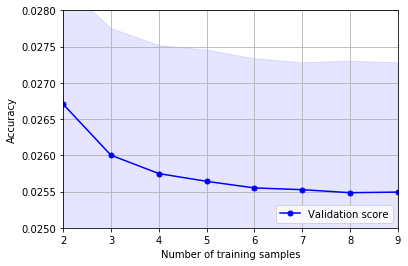

In [57]:
train_mean = np.mean(list(depth_dict.values()), axis=1)
train_std = np.std(list(depth_dict.values()), axis=1)


# Add plot of training accuracy
plt.plot(list(depth_dict.keys()), train_mean, color='blue', marker='o', markersize=5, label='Validation score')
# Add standard deviation
plt.fill_between(list(depth_dict.keys()), train_mean + train_std, train_mean - train_std, alpha=.1, color='blue')


plt.grid()

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.xlim([2, 9])
plt.ylim([0.025, 0.028])
plt.show()

In [74]:
t = time.time()

depth_dict_stra_shuffle={}
for splits in range(2,15):
    cvs = []
    kf = model_selection.StratifiedShuffleSplit(n_splits=splits, test_size=1/splits, random_state=1988)#KFold(n_splits=10, shuffle=True, random_state=30)
    for dev_index, val_index in kf.split(X,train['clusters'].values):
        dev_X, val_X = X.loc[dev_index], X.loc[val_index]
        dev_y, val_y = Y_fe.loc[dev_index], Y_fe.loc[val_index]
        y_pred_feen,rmsle_feen,y_pred_test_feen=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=8)
        cvs.append(rmsle_feen)
    depth_dict_stra_shuffle[splits]=cvs
    print('this took {0:.02f}-seconds with a mean validation rmsle of {1:.05f}'.format(time.time()-t, np.mean(cvs)))

this took 44.42-seconds with a mean validation rmsle of 0.02714
this took 104.75-seconds with a mean validation rmsle of 0.02594
this took 171.21-seconds with a mean validation rmsle of 0.02506
this took 259.48-seconds with a mean validation rmsle of 0.02535
this took 383.92-seconds with a mean validation rmsle of 0.02551
this took 516.85-seconds with a mean validation rmsle of 0.02570
this took 671.35-seconds with a mean validation rmsle of 0.02496
this took 867.04-seconds with a mean validation rmsle of 0.02549
this took 1082.12-seconds with a mean validation rmsle of 0.02678
this took 1305.66-seconds with a mean validation rmsle of 0.02545
this took 1534.65-seconds with a mean validation rmsle of 0.02605
this took 1767.19-seconds with a mean validation rmsle of 0.02621
this took 2024.66-seconds with a mean validation rmsle of 0.02675


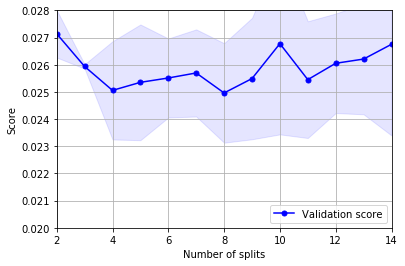

In [81]:
train_mean = np.array([np.mean(x) for x in list(depth_dict_stra_shuffle.values())])
train_std = np.array([np.std(x) for x in list(depth_dict_stra_shuffle.values())])


# Add plot of training accuracy
plt.plot(list(range(2,15)), train_mean, color='blue', marker='o', markersize=5, label='Validation score')
# Add standard deviation
plt.fill_between(list(range(2,15)), train_mean + train_std, train_mean - train_std, alpha=.1, color='blue')


plt.grid()

plt.xlabel('Number of splits')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.xlim([2, 14])
plt.ylim([0.02, 0.028])
plt.show()

In [ ]:
bestTest = 0.03425358731
bestIteration = 1200
this took 66.26484608650208-seconds with a mean validation rmsle of 0.026918040956777013

In [ ]:
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=30)
for dev_index, val_index in kf.split(X):
    dev_X, val_X = X.loc[dev_index], X.loc[val_index]
    dev_y, val_y = Y_bee.loc[dev_index], Y_bee.loc[val_index]
    y_pred_bee,rmsle_bee,y_pred_test_bee=runCatBoost(dev_X, dev_y, val_X, val_y,test,depth=4)
print("Mean cv score : ", np.mean(rmsle_bee))

In [ ]:
sub=pd.DataFrame()
sub["id"]=test_id
sub["formation_energy_ev_natom"]=np.exp(y_pred_test_feen)-1
sub["bandgap_energy_ev"]=np.exp(y_pred_test_bee)-1
rmsle_total=np.mean([rmsle_bee,rmsle_feen])
print(rmsle_total)
sub.to_csv(str(rmsle_total)+"_.csv",index=False)